# SPGR

In [1]:
import version_control

Last run on cashlab03-deb at 2015-03-19 10:45:41.305308

Phypno Version: 576776d12d121c044d9b3e79e7a3ee3d5ca04a2c

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.1, MarkupSafe==0.23, Pillow==2.7.0, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3.1, alabaster==0.7.2, bash-kernel==0.3, beautifulsoup4==4.3.2, biopython==1.65, certifi==14.05.14, coverage==3.7.1, decorator==3.4.0, docutils==0.12, easydev==0.8.3, ipython==3.0.0, jedi==0.8.1-final0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nltk==3.0.2, nose==1.3.4, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.15.2, pandocfilters==1.2.3, pep8==1.6.2, pexpect==3.3, pockets==0.2.3, psutil==2.2.1, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.1, python-igraph==0.7.1-4, pytz==2014.10, pyzmq==14.5.0, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.15.2, scipy==0.15.1, six==1.9.0, snowballstemmer==1.2.0,

In [2]:
from spgr import lg
lg.setLevel(10)

## Spindle Cooccurrence

### Parameters

Most spindles were synchronous only in one or a few channels at the same time (Fig. +[spgr_histogram]).
However, some spindles were widely distributed over up to 20 channels.

In [7]:
hemi_subj = {'EM09': 'rh', 
             'MG17': 'rh',
             'MG33': 'lh',
             'MG37': 'lh',
             'MG61': 'lh',
             'MG63': 'rh',
             }
all_subj = sorted(hemi_subj.keys())

In [23]:
options = {'reref': 'avg',
           'resample_freq': 256,
           'hp_filter': 0.5,
           'lp_filter': 50,
           }
chan_type = ('grid', 'strip')

In [9]:
spindles_options = {'method': 'Nir2011', 
                    'frequency': (9, 16), 
                    'duration':(0.5, 2),
                    }
spindles_options.update(options)

In [10]:
STD = 10
THRESHOLD = 20

### Code

In [11]:
%matplotlib inline
from matplotlib.pyplot import bar, savefig, xlabel, ylabel, close, plot, ylim, imshow, figure, colorbar, gca
import matplotlib 
matplotlib.rcParams.update({'font.size': 24})

In [12]:
from os import makedirs
from os.path import join
from numpy import arange, max
from spgr.detect_spindles import get_spindles
from spgr.plot_spindles import hist_overlap

In [37]:
img_dir = '/home/gio/projects/spgr/group/images'

In [14]:
from phypno.viz.base import Viz
from pyqtgraph import BarGraphItem, GraphicsLayoutWidget

In [15]:
width = 2
nchan = 30

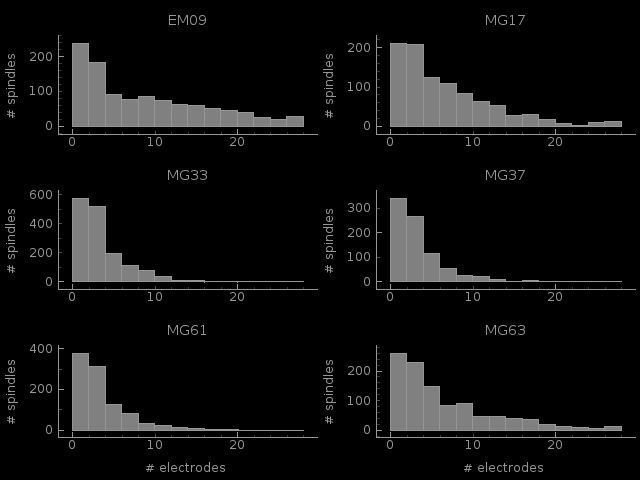

In [24]:
v = Viz()

w = GraphicsLayoutWidget()
v._widget = w

N_PER_ROW = 2
i = 0

for i, subj in enumerate(all_subj):

    if i % N_PER_ROW == 0:
        w.nextRow()
        
    spindles = get_spindles(subj, **spindles_options)

    h0, h1 = hist_overlap(spindles, width=width, nchan=nchan)
    
    p = w.addPlot(title=subj)

    bars = BarGraphItem(x0=h1[:-1], height=h0, width=width)
    p.setLabels(left='# spindles')
    p.addItem(bars)
    
    if i > 3:
        p.setLabels(bottom='# electrodes')

w.show()
# v.save(join(img_dir, 'hist_cooccurrence.png'))
v

### Plots of common spindles

In [25]:
from phypno import Data

In [26]:
from phypno.viz.plot_3d import Viz3
from spgr.read_data import get_data, REC_DIR, FS_PATH
from phypno.attr import Freesurfer
from numpy.linalg import norm

In [27]:
from phypno.source import Linear, Morph

STD = 10
THRESHOLD = 20

In [28]:
from spgr.stats_on_spindles import estimate_overlap
from numpy import asarray, sum, where, diff, r_, zeros, diag, mean, NaN, nanmean

In [29]:
all_elec = []
min_distance = None

for subj in all_subj:

    spindles = get_spindles(subj, **spindles_options)
    
    s = asarray([x['start_time'] for x in spindles.spindle])
    e = asarray([x['end_time'] for x in spindles.spindle])
    ov = estimate_overlap(s, e)

    x = sum(ov, axis=1)
    v = diff(r_[0, where(x == 1)[0]])

    sp_groups = []
    i0 = 0
    i1 = 0

    for one_v in v:
        i1 += one_v
        sp_groups.append(spindles.spindle[i0:i1])
        i0 += one_v

    chan_group = []
    for one_group in sp_groups:
        chan_group.append([x['chan'] for x in one_group])    

    data = get_data(subj, 'sleep', chan_type, **options)
    chan = data.attr['chan']
    all_chan = chan.return_label()
    
    chan_prob = zeros((chan.n_chan, chan.n_chan))

    for one_group in chan_group:
        for chan0 in one_group:
            i0 = all_chan.index(chan0)
            for chan1 in one_group:
                i1 = all_chan.index(chan1)
                chan_prob[i0, i1] += 1

    chan_dist = zeros((chan.n_chan, chan.n_chan))
    for i0 in range(chan.n_chan):
        for i1 in range(chan.n_chan):
            chan_dist[i0, i1] = norm(chan.chan[i0].xyz - chan.chan[i1].xyz)

    diag = chan_prob.diagonal().copy()
    if min_distance:
        chan_prob[chan_dist <= min_distance] = NaN  # use NaN to exclude chan too close
    
    chan_prob_n = chan_prob / diag

    if hemi_subj[subj] == 'lh':
        for one_chan in chan.chan:
            one_chan.xyz *= (-1, 1, 1)

    fs = Freesurfer(join(REC_DIR, subj, FS_PATH))
    surf = fs.read_surf('rh')

    data_chan = Data(nanmean(chan_prob_n, axis=1), chan=chan(func=lambda x: x.label in all_chan))

    l = Linear(surf, chan, std=STD, threshold=THRESHOLD)
    m = Morph(surf)
    all_elec.append(m(l(data_chan)))

INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj EM09, reading data: EM09_sleep_grid-strip_hp005_lp500_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:EM09 analysis chan 77, with location 77
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG17, reading data: MG17_sleep_grid-strip_hp005_lp500_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG17 analysis chan 104, with location 104
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG33, reading data: MG33_sleep_grid-strip_hp005_lp500_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG33 analysis chan 64, with location 64
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG37, reading data: MG37_sleep_grid-strip_hp005_lp500_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:MG37 analysis chan 78, with location 78
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj MG61, reading data: MG61_sleep_grid-strip_hp005_lp500_rs256.pk

In [30]:
from pyqtgraph import ImageWindow
import pyqtgraph as pg

In [53]:
from phypno.viz.base import Colormap, Viz
cm = Colormap('coolwarm', limits=(0, 1))

In [32]:
image(chan_prob_n)

NameError: name 'image' is not defined

In [33]:
# GUI
win = pg.GraphicsWindow()
view = win.addViewBox()
view.invertY()
view.setAspectLocked(True)
item = pg.ImageItem(chan_prob)
view.addItem(item)
item.setLookupTable(lut)
item.setLevels([0, 40])

v = Viz()
v._widget = win
v.size = 500, 400
# v.save('/home/gpiantoni/Copy/Presentations/2013_MGH/20150225_UCSD/img/avg/image_cooccurrence.png')
v

NameError: name 'lut' is not defined

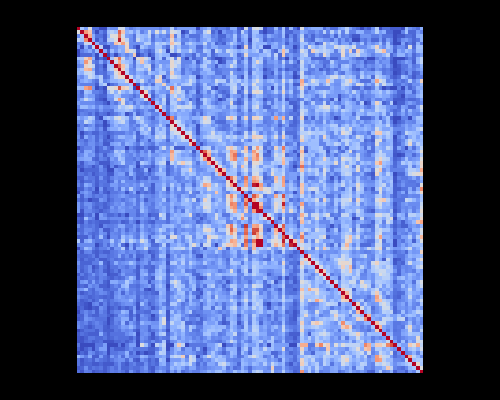

In [96]:
# GUI
win = pg.GraphicsWindow()
view = win.addViewBox()
view.invertY()
view.setAspectLocked(True)
item = pg.ImageItem(chan_prob_n)
view.addItem(item)
item.setLookupTable(lut)
item.setLevels([0, .5])

v = Viz()
v._widget = win
v.size = 500, 400
v.save('/home/gpiantoni/Copy/Presentations/2013_MGH/20150225_UCSD/img/avg/ratio_cooccurrence.png')
v

In [34]:
from spgr.plot_spindles import plot_surf

In [45]:
v = plot_surf(all_elec, (0.001, None), (0, .2))
v._widget.setBackgroundColor('w')

/home/gio/projects/spgr/scripts/spgr/plot_spindles.py:47: RuntimeWarning: invalid value encountered in less
  x.data[0][x.data[0] < threshold[0]] = NaN
/home/gio/tools/venv/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Spindles in the prefrontal cortex are mostly likely to co-occur with spindles in other brain areas (Fig. +[spgr_topo_cooccur]).

In [46]:
if min_distance:
    v.save(join(img_dir, 'sync_spindles_min{}.png'.format(min_distance)))
else:
    v.save(join(img_dir, 'sync_spindles.png'.format(min_distance)))

In [61]:
from pyqtgraph import GradientWidget

w = GradientWidget(orientation='left')
w.show()

In [62]:
w.item.setColorMap(cm)